# ASPEN Paper - Figure 3 and its supplement

In [169]:
# Loading required libraries
suppressPackageStartupMessages({
    library(openxlsx)
    library(scales)
    library(scater)
    library(dplyr)
    library(gamlss)
    library(ggplot2)
    library(ggpointdensity)
    library(ggsci)
    library(ggthemes)
    library(gridExtra)
    library(ggpubr)
    library(scales)
    library(foreach)
    library(reshape2)
    library(locfit)
    library(scran)
    library(zoo)
    library(ComplexHeatmap)
    library(ASPEN)
})

Functions used to generate the plots.

In [143]:
# Plotting allelic dispersion estimates over mean gene expression
plot_disp_fit_theta <- function(param_reestim, midpoint = 2000, gene = gene){
    
    ggplot(param_reestim, aes(log(tot_gene_mean), log(bb_theta))) +
        geom_pointdensity(size = 0.7) +
        geom_smooth(data = param_reestim[param_reestim$bb_theta > 1e-03,], method = "locfit", color = "#01a2d9", linewidth = 0.7, se = F) +
        theme_classic(base_size = 20) +
        theme(legend.position = "none", legend.title = element_blank()) +
        scale_color_gradient2(low = "#003C67FF", mid = "#EFC000FF", high = "#A73030FF", midpoint = midpoint) +
        annotate("text", x=2, y=1, label= paste("N genes:", nrow(param_reestim)))  
}

# True positive rate calculation
calc_tpr <- function(pvals, sequence){
  
    tpr <- vector()
    tp <- vector()
    fn <- vector()
    
    for (i in seq_along(sequence)){
      prediction <- ifelse(pvals <= sequence[i], 1, 0)
      df <- as.data.frame(prediction)
      t <- df %>% dplyr::group_by(prediction) %>% tally()
      t <- as.data.frame(t)
      tp[i] <- ifelse(length(t[t$prediction == 1, "n"]) != 0, 
                      t[t$prediction == 1, "n"], 0) #true positives
      fn[i] <- ifelse(length(t[t$prediction == 0, "n"]) != 0,
                      t[t$prediction == 0, "n"], 0) #false negative
    }
    
   
    for (i in seq_along(sequence)){
      tpr[i] <- tp[i]/(tp[i]+fn[i])
    }
    
    list(tp = tp, fn = fn, tpr = tpr)
  
}

# Barplot of true positive rates
barplot_tpr <- function(df){
  ggplot(df, aes(x = as.factor(AR_vec), y = mean, fill = test, color = test)) +
    geom_col(position = "dodge", width = 0.7) +
    theme_classic(base_size = 20) +
    theme(panel.grid.minor = element_blank()) +
    theme(legend.title = element_blank(), legend.position = "bottom", legend.box.spacing = unit(0, "pt")) +
    labs(y = "Power", x = "Effect size (Deviation from AR = 0.5)") +
    scale_fill_manual(values = c("white", "black"), labels = c("No Shrinkage", "With Shrinkage")) +
    scale_color_manual(values = c("black", "black"), labels = c("No Shrinkage", "With Shrinkage"))
}

#Line plot of true positive rates
plot_tpr <- function(df){
  ggplot(df) +
   geom_line(aes(x = AR_vec, y = mean, colour = test))+
    geom_point(aes(x = AR_vec, y = mean, colour = test))+
    theme_classic(base_size = 20) +
    theme(panel.grid.minor = element_blank()) +
    theme(legend.title = element_blank(), legend.position = "bottom", legend.box.spacing = unit(0, "pt")) +
    labs(y = "Pwer", x = "Effect size (Deviation from AR = 0.5)") +
    scale_color_manual(values = pal_jama("default")(2)[2:1], labels = c("scDALI", "ASPEN"))
}


#Preparing data for plotting
#this function extracts allelic counts and calculates allelic ratio for each cell
makedf <- function(a1, a2, gene){
  
  df <- as.data.frame(cbind(a1 = as.vector(a1[gene,]), a2 = as.vector(a2[gene,])))
  df$a1 <- as.numeric(df$a1)
  df$a2 <- as.numeric(df$a2)
  df$tot <- df$a1 + df$a2
  df$AR <- df$a1/df$tot
  #df <- df[order(df$tot),]
  df <- na.omit(df)
  df$Index <- 1:nrow(df)
  df
}

#scatter plot to evaluate allelic ratio distribution
#points are coloured by total counts
plot_distr_totGE <- function(plot_data, gene){
    
  p <- plot_data %>% ggplot(aes(AR, Index, colour = log(tot))) +
    theme_classic(base_size = 15) +
    geom_pointdensity(size = 0.9) +
    geom_vline(xintercept=0.5, linetype='longdash', color='lightgrey') +
    theme(plot.subtitle = element_text(hjust = 1)) +
    scale_colour_viridis_c(option = "mako", direction = -1) +
    theme(legend.position = "bottom", legend.box.spacing = unit(0, "pt"),
          axis.title.y = element_blank(), axis.text.y = element_blank()) +
    labs(x = "Allelic ratio") +
    xlim(0,1)
  p2 <-ggExtra::ggMarginal(p, type = "density", margin = "x", groupColour = F, groupFill = F, size = 3)
    
    p2

}

# scatterplot with density kernel
plot_scatter_kernel <- function(plot_data){
  
  ggplot(data=plot_data, aes(x = -log10(scRNA.fdr_bayes), y = -log10(pseudo_bulk.fdr_bayes))) +
          geom_pointdensity() +
          theme(legend.position = c(0.2, 0.8)) +
          theme_classic(base_size = 20) +
          theme(panel.border = element_rect(colour = "black", fill=NA, size=1)) +
          geom_abline(linetype = "dashed") +
          theme(legend.direction = "vertical", legend.position = "none") +
          annotate("text", x=110, y=300, label= paste("Pearson's rho: ", round(cor(plot_data$scRNA.fdr_bayes, 
                                                                                   plot_data$pseudo_bulk.fdr_bayes, 
                                                                                   use = "complete.obs"), 2)), size = 6) +
          scale_colour_viridis_c(option = "magma", direction = -1, begin = 0.25, end = 0.7)
}

### Figure 3A
Log-transformed dispersion estimates over mean gene expression level with the locfit model trend. This plot is based on the estimates obtained from the T-cells dataset. Only genes with sufficinet expression (a minimum 5 reads in at least five cells) are included.

In [5]:
#scRNA results
res_dir <- "./aspen_output/tcells/"
samples <- list("cd8_naive", "cd8_d07_lcmv_arms", "cd8_d40_lcmv_arms")
bb_test_res_tcells <- lapply(samples, function(q) read.xlsx(paste0(res_dir, "tcells_lcmv_ASPENmean.xlsx"),
                                                            sheet = q, rowNames = T))
#all cell states are combined for plottting
tcells_scRNA_comb <- do.call(rbind, bb_test_res_tcells)

Warning message:
“Removed 126 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”
`geom_smooth()` using formula = 'y ~ x'


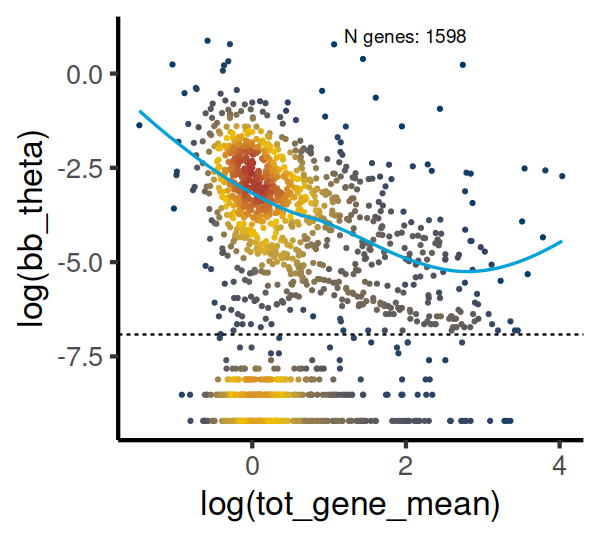

In [8]:
options(repr.plot.width = 5, repr.plot.height = 4.5)
plot_disp_fit_theta(tcells_scRNA_comb, midpoint = 80) +
    geom_hline(yintercept = log(1e-03), linetype = "dashed", linewidth = 0.5)

### Figure 3B
Comparing performance of ASPEN mean test with shrinkage and without shrinkage. Simulated data was used for this analysis.

Allelic counts were simulated with multiple mean allelic ratio values. Each bb_test_res object contains a list of ASPEN results for the respective mean AR value. Simulation was repeated five times. Each ASPEN run was saved separately.

In [10]:
#Loading test results
#genes with low dispersion are not filtered out, all dispersion values are shrunk

AR_vec <- list(0.10, 0.30, 0.35, 0.40, 0.42, 0.45, 0.47, 0.50, 0.52, 0.55, 0.57, 0.60, 0.65, 0.70, 0.90)
simul_dir <- "./aspen_output/simulated/"

bb_test_res_iter1 <- readRDS(paste0(simul_dir, "bb_test_res_iter1.rds"))
bb_test_res_iter2 <- readRDS(paste0(simul_dir, "bb_test_res_iter2.rds"))
bb_test_res_iter3 <- readRDS(paste0(simul_dir, "bb_test_res_iter3.rds"))
bb_test_res_iter4 <- readRDS(paste0(simul_dir, "bb_test_res_iter4.rds"))
bb_test_res_iter5 <- readRDS(paste0(simul_dir, "bb_test_res_iter5.rds"))

#additional simulated datasets
AR_vec_add <- list(0.46, 0.48, 0.49, 0.51, 0.53, 0.54)
bb_test_res_iter1_add <- readRDS(paste0(simul_dir, "bb_test_res_iter1_additional.rds"))
bb_test_res_iter2_add <- readRDS(paste0(simul_dir, "bb_test_res_iter2_additional.rds"))
bb_test_res_iter3_add <- readRDS(paste0(simul_dir, "bb_test_res_iter3_additional.rds"))
bb_test_res_iter4_add <- readRDS(paste0(simul_dir, "bb_test_res_iter4_additional.rds"))
bb_test_res_iter5_add <- readRDS(paste0(simul_dir, "bb_test_res_iter5_additional.rds"))

In [11]:
#combining test results
AR_all <- c(AR_vec, AR_vec_add)
AR_all <- AR_all[c(1:6,16,7,17:18,8,19,9,20:21,10:15)]
do.call(c, AR_all)

[1] 0.10 0.30 0.35 0.40 0.42 0.45 0.46 0.47 0.48 0.49 0.50 0.51 0.52 0.53 0.54
[16] 0.55 0.57 0.60 0.65 0.70 0.90

In [12]:
bb_test_res_iter1 <- c(bb_test_res_iter1, bb_test_res_iter1_add)
bb_test_res_iter2 <- c(bb_test_res_iter2, bb_test_res_iter2_add)
bb_test_res_iter3 <- c(bb_test_res_iter3, bb_test_res_iter3_add)
bb_test_res_iter4 <- c(bb_test_res_iter4, bb_test_res_iter4_add)
bb_test_res_iter5 <- c(bb_test_res_iter5, bb_test_res_iter5_add)

bb_test_res_iter1 <- bb_test_res_iter1[c(1:6,16,7,17:18,8,19,9,20:21,10:15)]
bb_test_res_iter2 <- bb_test_res_iter2[c(1:6,16,7,17:18,8,19,9,20:21,10:15)]
bb_test_res_iter3 <- bb_test_res_iter3[c(1:6,16,7,17:18,8,19,9,20:21,10:15)]
bb_test_res_iter4 <- bb_test_res_iter4[c(1:6,16,7,17:18,8,19,9,20:21,10:15)]
bb_test_res_iter5 <- bb_test_res_iter5[c(1:6,16,7,17:18,8,19,9,20:21,10:15)]

In [13]:
# Calculating FDR
# here pval_orig correspond to the p-values obtained without shrinkage
# and pval_adj - with shrinkage
bb_test_res_iter1 <- lapply(bb_test_res_iter1, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter1";
                                                            return(q)})
bb_test_res_iter2 <- lapply(bb_test_res_iter2, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter2";
                                                            return(q)})
bb_test_res_iter3 <- lapply(bb_test_res_iter3, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter3";
                                                            return(q)})
bb_test_res_iter4 <- lapply(bb_test_res_iter4, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter4";
                                                            return(q)})
bb_test_res_iter5 <- lapply(bb_test_res_iter5, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter5";
                                                            return(q)})

In [14]:
# calculating TPM and dividing genes into groups based on TPM
# loading total counts that were used for the simulation
simul_data <- "./data/simulated/"
sim_tot_counts <- readRDS(paste0(simul_data, "sim_tot_hvg2000.rds")) #this is zinbwave output
sim_tot_counts <- sim_tot_counts[["counts"]] #extracting total counts
TPM_iter1 <- calculateTPM(sim_tot_counts[bb_test_res_iter1[[1]]$id,], lengths = NULL)
TPM_iter1_mean <- as.data.frame(rowMeans(TPM_iter1))
colnames(TPM_iter1_mean)[1] <- "TPM"

# underlying total counts were the same for each allelic count simulate,
# so TPM values are simply added to each object
bb_test_res_iter1 <- lapply(bb_test_res_iter1, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})
bb_test_res_iter2 <- lapply(bb_test_res_iter2, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})
bb_test_res_iter3 <- lapply(bb_test_res_iter3, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})
bb_test_res_iter4 <- lapply(bb_test_res_iter4, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})
bb_test_res_iter5 <- lapply(bb_test_res_iter5, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})

In [15]:
#combining datasets together
bb_test_res_all <- Map(rbind, bb_test_res_iter1, bb_test_res_iter2, bb_test_res_iter3, bb_test_res_iter4, bb_test_res_iter5)
#removing genes which were excluded from testing
#such genes did not meet filtering criteria (i.e. they had less than 5 cells with 5 or more reads mapped
bb_test_res_all <- lapply(bb_test_res_all, function(q) q[!(is.na(q$fdr_bayes)),])

In [17]:
#assigning genes into groupd based on GE
bb_test_res_all <- lapply(bb_test_res_all, function(q) {q$ge_group <- cut(q$tot_gene_mean, breaks=c(quantile(q$tot_gene_mean, c(0, 0.4, 0.9, 1))));
                                                  return(q)})

bb_test_res_all <- lapply(bb_test_res_all, function(q) {levels(q$ge_group) <- c("lowGE", "medGE", "highGE");
                                                return(q)})

In [18]:
#assigning genes into groups based on dispersion 
bb_test_res_all  <- lapply(bb_test_res_all , function(q) {q$disp_group <- sapply(q$theta_reestim, function(r) if (r <= 0.005) "low disp"
                                                                                                     else if (r <= 0.4) "med disp"
                                                                                                     else if (r > 0.4) "high disp");
                                                return(q)})
bb_test_res_all <- lapply(bb_test_res_all, function(q) {q$disp_group <- factor(q$disp_group, levels = c("low disp", "med disp", "high disp"));
                                                return(q)})

In [19]:
#Splitting results by GE and dispersion
bb_test_res_disp_group <- lapply(bb_test_res_all, function(q) split(q, f = q$disp_group))

bb_test_res_disp_ge_group <- lapply(bb_test_res_disp_group, function(r) lapply(r, function(q) split(q, f = q$ge_group)))

In [22]:
#Calculating TPR for each group
#fdr cut-off is set to 0.001
range <- 1e-03
tpr_orig <- lapply(bb_test_res_disp_ge_group, function(p) 
                      lapply(p, function(q) 
                        lapply(q, function(r) calc_tpr(r$fdr_orig, range))))
tpr_bayes <- lapply(bb_test_res_disp_ge_group, function(p) 
                        lapply(p, function(q)
                          lapply(q, function(r) calc_tpr(r$fdr_bayes, range))))

In [23]:
#extracting fpr and tpr values
stats_orig <- lapply(tpr_orig, function(p) lapply(p, function(q) 
                      lapply(q, function(r) as.data.frame(cbind(tp = r$tp, fn = r$fn, tpr = r$tpr)))))
stats_bayes <- lapply(tpr_bayes, function(p) lapply(p, function(q) 
                      lapply(q, function(r) as.data.frame(cbind(tp = r$tp, fn = r$fn, tpr = r$tpr)))))


#adding group variable
for (i in 1:length(stats_orig)){
  for(j in 1:length(stats_orig[[i]])){
    for(k in 1:length(stats_orig[[i]][[j]])){
      stats_orig[[i]][[j]][[k]]$disp_group <- names(stats_orig[[i]])[j]
      stats_orig[[i]][[j]][[k]]$GE_group <- names(stats_orig[[i]][[j]])[k]
      stats_orig[[i]][[j]][[k]]$test <- "nonBayes"
      stats_orig[[i]][[j]][[k]]$meanAR <- as.character(AR_all[[i]])
      stats_orig[[i]][[j]][[k]]$FDR <- range
      names(stats_orig)[i] <- AR_all[i]
    }  
  }
}

for (i in 1:length(stats_bayes)){
  for(j in 1:length(stats_bayes[[i]])){
    for(k in 1:length(stats_bayes[[i]][[j]])){
      stats_bayes[[i]][[j]][[k]]$disp_group <- names(stats_bayes[[i]])[j]
      stats_bayes[[i]][[j]][[k]]$GE_group <- names(stats_bayes[[i]][[j]])[k]
      stats_bayes[[i]][[j]][[k]]$test <- "Bayes"
      stats_bayes[[i]][[j]][[k]]$meanAR <- as.character(AR_all[[i]])
      stats_bayes[[i]][[j]][[k]]$FDR <- range
      names(stats_bayes)[i] <- AR_all[i]
    }
  }
}

head(stats_bayes[[1]][[1]])  

tp,fn,tpr,disp_group,GE_group,test,meanAR,FDR
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
186,0,1,low disp,lowGE,Bayes,0.1,0.001
tp,fn,tpr,disp_group,GE_group,test,meanAR,FDR
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
154,0,1,low disp,medGE,Bayes,0.1,0.001
tp,fn,tpr,disp_group,GE_group,test,meanAR,FDR
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
21,0,1,low disp,highGE,Bayes,0.1,0.001


In [24]:
#flattening the lists with tpr calculations
stats_orig <- lapply(stats_orig, function(q) unlist(q, recursive = F))
stats_bayes <- lapply(stats_bayes, function(q) unlist(q, recursive = F))

#combining dispersion groups within GE groups
stats_orig <- lapply(stats_orig, function(q) do.call(rbind, q))
stats_bayes <- lapply(stats_bayes, function(q) do.call(rbind, q))

#combining results for all tests into one data frame
stats <-  Map(rbind, stats_orig, stats_bayes)
stats <- lapply(stats, function(q) {q$test <- factor(q$test, 
                                                     levels = c("nonBayes", "Bayes"));
                                                        return(q)})
head(stats[[1]])    

,tp,fn,tpr,disp_group,GE_group,test,meanAR,FDR
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>
low disp.lowGE,186,0,1,low disp,lowGE,nonBayes,0.1,0.001
low disp.medGE,154,0,1,low disp,medGE,nonBayes,0.1,0.001
low disp.highGE,21,0,1,low disp,highGE,nonBayes,0.1,0.001
med disp.lowGE,670,0,1,med disp,lowGE,nonBayes,0.1,0.001
med disp.medGE,939,0,1,med disp,medGE,nonBayes,0.1,0.001
med disp.highGE,194,0,1,med disp,highGE,nonBayes,0.1,0.001


In [25]:
options(warn = -1)
summary <- lapply(stats, function(q) q %>% dplyr::group_by(test, meanAR, GE_group, disp_group) %>% 
                                      summarize(mean = mean(tpr)))

summary <- do.call(rbind, summary)
summary$meanAR <- as.numeric(summary$meanAR)
summary$AR_vec <- abs(0.5 - summary$meanAR)
head(summary)

`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.g

test,meanAR,GE_group,disp_group,mean,AR_vec
<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
nonBayes,0.1,highGE,high disp,1,0.4
nonBayes,0.1,highGE,low disp,1,0.4
nonBayes,0.1,highGE,med disp,1,0.4
nonBayes,0.1,lowGE,high disp,1,0.4
nonBayes,0.1,lowGE,low disp,1,0.4
nonBayes,0.1,lowGE,med disp,1,0.4


In [27]:
summary$GE_group <- recode(summary$GE_group, lowGE = "log(TPM) < 3", medGE = "log(TPM) < 8", highGE = "log(TPM) > 8")

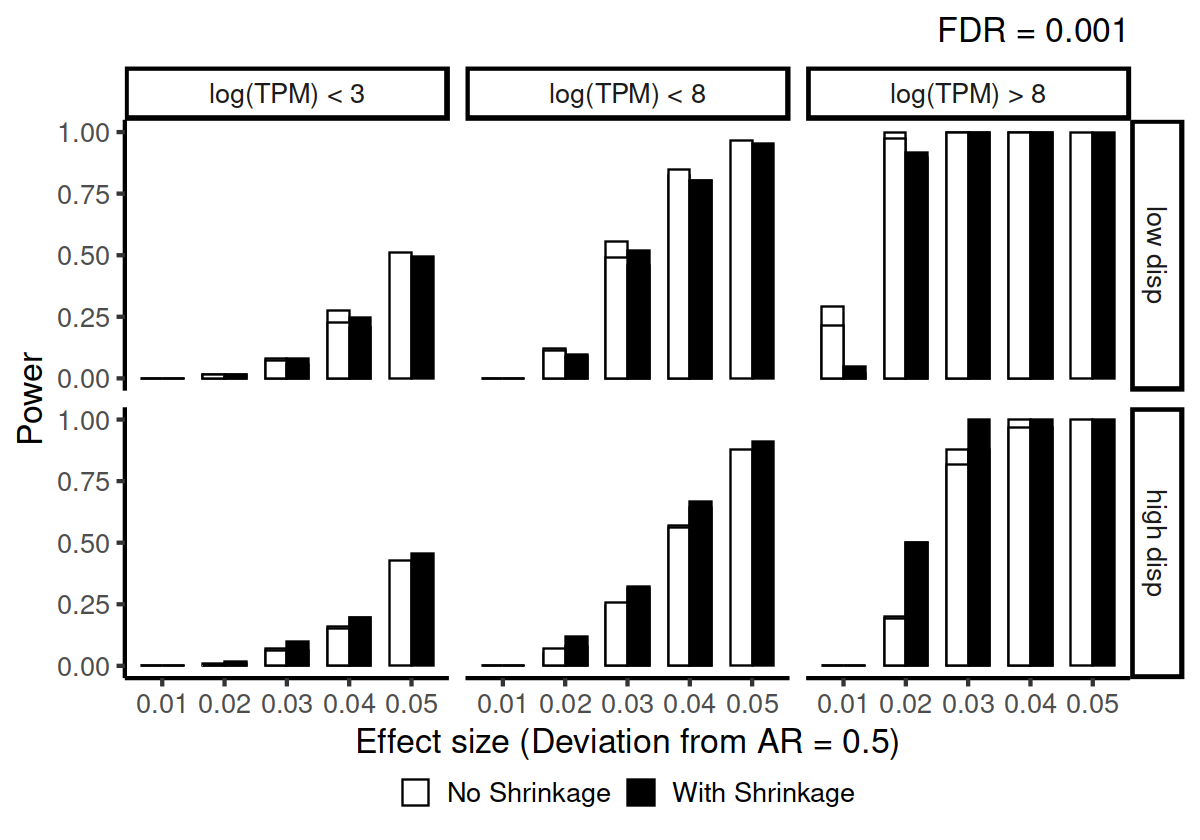

In [36]:
options(repr.plot.width = 10, repr.plot.height = 7)
summary_sub <- summary[summary$AR_vec < 0.05,]
summary_sub <- summary_sub[!(summary_sub$AR_vec) == 0,] 
summary_sub <- summary_sub[!(summary_sub$disp_group %in% "med disp"),]
barplot_tpr(summary_sub) + 
facet_grid(factor(disp_group, levels = c("low disp", "high disp")) ~ factor(GE_group, levels = c("log(TPM) < 3", "log(TPM) < 8", "log(TPM) > 8"))) +
labs(subtitle = "FDR = 0.001") + theme(plot.subtitle = element_text(hjust = 1)) 

### Figure 3C and Supplemental Figure 2A

Comparing the results of ASPEN-mean and scDALI-Hom tests.

In [56]:
#Loading test results
AR_vec <- list(0.10, 0.30, 0.35, 0.40, 0.42, 0.45, 0.47, 0.50, 0.52, 0.55, 0.57, 0.60, 0.65, 0.70, 0.90)
simul_dir <- "./aspen_output/simulated/"

bb_test_res_iter1 <- readRDS(paste0(simul_dir, "bb_test_res_iter1.rds"))
bb_test_res_iter2 <- readRDS(paste0(simul_dir, "bb_test_res_iter2.rds"))
bb_test_res_iter3 <- readRDS(paste0(simul_dir, "bb_test_res_iter3.rds"))
bb_test_res_iter4 <- readRDS(paste0(simul_dir, "bb_test_res_iter4.rds"))
bb_test_res_iter5 <- readRDS(paste0(simul_dir, "bb_test_res_iter5.rds"))


In [58]:
# Calculating FDR
# here pval_orig correspond to the p-values obtained without shrinkage
# and pval_adj - with shrinkage
bb_test_res_iter1 <- lapply(bb_test_res_iter1, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter1";
                                                            return(q)})
bb_test_res_iter2 <- lapply(bb_test_res_iter2, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter2";
                                                            return(q)})
bb_test_res_iter3 <- lapply(bb_test_res_iter3, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter3";
                                                            return(q)})
bb_test_res_iter4 <- lapply(bb_test_res_iter4, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter4";
                                                            return(q)})
bb_test_res_iter5 <- lapply(bb_test_res_iter5, function(q) {q$fdr_orig <- ifelse(!is.na(q$pval_orig), p.adjust(q$pval_orig, method = "fdr"), NA);
                                                            q$fdr_bayes <- ifelse(!is.na(q$pval_adj), p.adjust(q$pval_adj, method = "fdr"), NA);
                                                            q$rep <- "iter5";
                                                            return(q)})

In [59]:
#loading scdali results and adding them to the ASPEN's
scdali_hom_iter1 <- readRDS(paste0(simul_dir, "scdali_hom_pval_iter1.rds"))
scdali_hom_iter1 <- lapply(scdali_hom_iter1, function(q) as.numeric(q$pvalues))


bb_test_res_iter1 <- mapply(function(p, q) {p$pvalue_scDALI <- q[p$id];
                            p$fdr_scDALI <- p.adjust(p$pvalue_scDALI, method = "fdr");
                            p$fdr_scDALI <- ifelse(is.na(p$fdr_scDALI), 1, p$fdr_scDALI);
                            return(p)}, bb_test_res_iter1, scdali_hom_iter1, SIMPLIFY = F)

scdali_hom_iter2 <- readRDS(paste0(simul_dir, "scdali_hom_pval_iter2.rds"))
scdali_hom_iter2 <- lapply(scdali_hom_iter2, function(q) as.numeric(q$pvalues))


bb_test_res_iter2 <- mapply(function(p, q) {p$pvalue_scDALI <- q[p$id];
                            p$fdr_scDALI <- p.adjust(p$pvalue_scDALI, method = "fdr");
                            p$fdr_scDALI <- ifelse(is.na(p$fdr_scDALI), 1, p$fdr_scDALI);
                            return(p)}, bb_test_res_iter2, scdali_hom_iter2, SIMPLIFY = F)

scdali_hom_iter3 <- readRDS(paste0(simul_dir, "scdali_hom_pval_iter3.rds"))
scdali_hom_iter3 <- lapply(scdali_hom_iter3, function(q) as.numeric(q$pvalues))


bb_test_res_iter3 <- mapply(function(p, q) {p$pvalue_scDALI <- q[p$id];
                            p$fdr_scDALI <- p.adjust(p$pvalue_scDALI, method = "fdr");
                            p$fdr_scDALI <- ifelse(is.na(p$fdr_scDALI), 1, p$fdr_scDALI);
                            return(p)}, bb_test_res_iter3, scdali_hom_iter3, SIMPLIFY = F)

scdali_hom_iter4 <- readRDS(paste0(simul_dir, "scdali_hom_pval_iter4.rds"))
scdali_hom_iter4 <- lapply(scdali_hom_iter4, function(q) as.numeric(q$pvalues))


bb_test_res_iter4 <- mapply(function(p, q) {p$pvalue_scDALI <- q[p$id];
                            p$fdr_scDALI <- p.adjust(p$pvalue_scDALI, method = "fdr");
                            p$fdr_scDALI <- ifelse(is.na(p$fdr_scDALI), 1, p$fdr_scDALI);
                            return(p)}, bb_test_res_iter4, scdali_hom_iter4, SIMPLIFY = F)

scdali_hom_iter5 <- readRDS(paste0(simul_dir, "scdali_hom_pval_iter5.rds"))
scdali_hom_iter5 <- lapply(scdali_hom_iter5, function(q) as.numeric(q$pvalues))


bb_test_res_iter5 <- mapply(function(p, q) {p$pvalue_scDALI <- q[p$id];
                            p$fdr_scDALI <- p.adjust(p$pvalue_scDALI, method = "fdr");
                            p$fdr_scDALI <- ifelse(is.na(p$fdr_scDALI), 1, p$fdr_scDALI);
                            return(p)}, bb_test_res_iter5, scdali_hom_iter5, SIMPLIFY = F)


In [60]:
# calculating TPM and dividing genes into groups based on TPM
# loading total counts that were used for the simulation
sim_tot_counts <- readRDS(paste0(simul_data, "sim_tot_hvg2000.rds")) #this is zinbwave output
sim_tot_counts <- sim_tot_counts[["counts"]] #extracting total counts
TPM_iter1 <- calculateTPM(sim_tot_counts[bb_test_res_iter1[[1]]$id,], lengths = NULL)
TPM_iter1_mean <- as.data.frame(rowMeans(TPM_iter1))
colnames(TPM_iter1_mean)[1] <- "TPM"

# underlying total counts were the same for each allelic count simulate,
# so TPM values are simply added to each object
bb_test_res_iter1 <- lapply(bb_test_res_iter1, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})
bb_test_res_iter2 <- lapply(bb_test_res_iter2, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})
bb_test_res_iter3 <- lapply(bb_test_res_iter3, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})
bb_test_res_iter4 <- lapply(bb_test_res_iter4, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})
bb_test_res_iter5 <- lapply(bb_test_res_iter5, function(q) {q$TPM <- TPM_iter1_mean$TPM;
                                                            return(q)})

In [62]:
#combining datasets together
bb_test_res_all <- Map(rbind, bb_test_res_iter1, bb_test_res_iter2, bb_test_res_iter3, bb_test_res_iter4, bb_test_res_iter5)
#removing genes which were excluded from testing
#such genes did not meet filtering criteria (i.e. they had less than 5 cells with 5 or more reads mapped
bb_test_res_all <- lapply(bb_test_res_all, function(q) q[!(is.na(q$fdr_bayes)),])

In [64]:
#assigning genes into groupd based on GE
bb_test_res_all <- lapply(bb_test_res_all, function(q) {q$ge_group <- cut(q$tot_gene_mean, breaks=c(quantile(q$tot_gene_mean, c(0, 0.4, 0.9, 1))));
                                                  return(q)})

bb_test_res_all <- lapply(bb_test_res_all, function(q) {levels(q$ge_group) <- c("lowGE", "medGE", "highGE");
                                                return(q)})


In [65]:
#assigning genes into groups based on dispersion 
bb_test_res_all  <- lapply(bb_test_res_all , function(q) {q$disp_group <- sapply(q$theta_reestim, function(r) if (r <= 0.005) "low disp"
                                                                                                     else if (r <= 0.1) "med disp"
                                                                                                     else if (r > 0.1) "high disp");
                                                return(q)})
bb_test_res_all <- lapply(bb_test_res_all, function(q) {q$disp_group <- factor(q$disp_group, levels = c("low disp", "med disp", "high disp"));
                                                return(q)})

In [66]:
#Splitting results by GE and dispersion
bb_test_res_disp_group <- lapply(bb_test_res_all, function(q) split(q, f = q$disp_group))

bb_test_res_disp_ge_group <- lapply(bb_test_res_disp_group, function(r) lapply(r, function(q) split(q, f = q$ge_group)))


In [67]:
#Calculating TPR for each group
#fdr cut-off is set to 0.001
range <- 1e-03
tpr_orig <- lapply(bb_test_res_disp_ge_group, function(p) 
                      lapply(p, function(q) 
                        lapply(q, function(r) calc_tpr(r$fdr_orig, range))))
tpr_bayes <- lapply(bb_test_res_disp_ge_group, function(p) 
                        lapply(p, function(q)
                          lapply(q, function(r) calc_tpr(r$fdr_bayes, range))))
tpr_scdali <- lapply(bb_test_res_disp_ge_group, function(p) 
                        lapply(p, function(q)
                          lapply(q, function(r) calc_tpr(r$fdr_scDALI, range))))

In [68]:
#extracting fpr and tpr values
stats_orig <- lapply(tpr_orig, function(p) lapply(p, function(q) 
                      lapply(q, function(r) as.data.frame(cbind(tp = r$tp, fn = r$fn, tpr = r$tpr)))))
stats_bayes <- lapply(tpr_bayes, function(p) lapply(p, function(q) 
                      lapply(q, function(r) as.data.frame(cbind(tp = r$tp, fn = r$fn, tpr = r$tpr)))))
stats_scdali <- lapply(tpr_scdali, function(p) lapply(p, function(q) 
                      lapply(q, function(r) as.data.frame(cbind(tp = r$tp, fn = r$fn, tpr = r$tpr)))))


#adding group variable
for (i in 1:length(stats_orig)){
  for(j in 1:length(stats_orig[[i]])){
    for(k in 1:length(stats_orig[[i]][[j]])){
      stats_orig[[i]][[j]][[k]]$disp_group <- names(stats_orig[[i]])[j]
      stats_orig[[i]][[j]][[k]]$GE_group <- names(stats_orig[[i]][[j]])[k]
      stats_orig[[i]][[j]][[k]]$test <- "nonBayes"
      stats_orig[[i]][[j]][[k]]$meanAR <- as.character(AR_vec[[i]])
      stats_orig[[i]][[j]][[k]]$FDR <- range
      names(stats_orig)[i] <- AR_vec[i]
    }  
  }
}

for (i in 1:length(stats_bayes)){
  for(j in 1:length(stats_bayes[[i]])){
    for(k in 1:length(stats_bayes[[i]][[j]])){
      stats_bayes[[i]][[j]][[k]]$disp_group <- names(stats_bayes[[i]])[j]
      stats_bayes[[i]][[j]][[k]]$GE_group <- names(stats_bayes[[i]][[j]])[k]
      stats_bayes[[i]][[j]][[k]]$test <- "Bayes"
      stats_bayes[[i]][[j]][[k]]$meanAR <- as.character(AR_vec[[i]])
      stats_bayes[[i]][[j]][[k]]$FDR <- range
      names(stats_bayes)[i] <- AR_vec[i]
    }
  }
}


for (i in 1:length(stats_scdali)){
  for(j in 1:length(stats_scdali[[i]])){
    for(k in 1:length(stats_scdali[[i]][[j]])){
      stats_scdali[[i]][[j]][[k]]$disp_group <- names(stats_scdali[[i]])[j]
      stats_scdali[[i]][[j]][[k]]$GE_group <- names(stats_scdali[[i]][[j]])[k]
      stats_scdali[[i]][[j]][[k]]$test <- "scDALI"
      stats_scdali[[i]][[j]][[k]]$meanAR <- as.character(AR_vec[[i]])
      stats_scdali[[i]][[j]][[k]]$FDR <- range
      names(stats_scdali)[i] <- AR_vec[i]
    }
  }
}

In [69]:
#flattening the lists with tpr calculations
stats_orig <- lapply(stats_orig, function(q) unlist(q, recursive = F))
stats_bayes <- lapply(stats_bayes, function(q) unlist(q, recursive = F))
stats_scdali <- lapply(stats_scdali, function(q) unlist(q, recursive = F))

#combining dispersion groups within GE groups
stats_orig <- lapply(stats_orig, function(q) do.call(rbind, q))
stats_bayes <- lapply(stats_bayes, function(q) do.call(rbind, q))
stats_scdali <- lapply(stats_scdali, function(q) do.call(rbind, q))

#combining results for all tests into one data frame
stats <-  Map(rbind, stats_orig, stats_bayes, stats_scdali)
stats <- lapply(stats, function(q) {q$test <- factor(q$test, 
                                                     levels = c("scDALI", "nonBayes", "Bayes"));
                                                        return(q)})
                       

In [70]:
summary <- lapply(stats, function(q) q %>% dplyr::group_by(test, meanAR, GE_group, disp_group) %>% 
                                      summarize(mean = mean(tpr)))

summary <- do.call(rbind, summary)
summary$meanAR <- as.numeric(summary$meanAR)
summary$AR_vec <- abs(0.5 - summary$meanAR)

`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'test', 'meanAR', 'GE_group'. You can
override using the `.g

In [71]:
summary$GE_group <- recode(summary$GE_group, lowGE = "log(TPM) < 3", medGE = "log(TPM) < 8", highGE = "log(TPM) > 8")

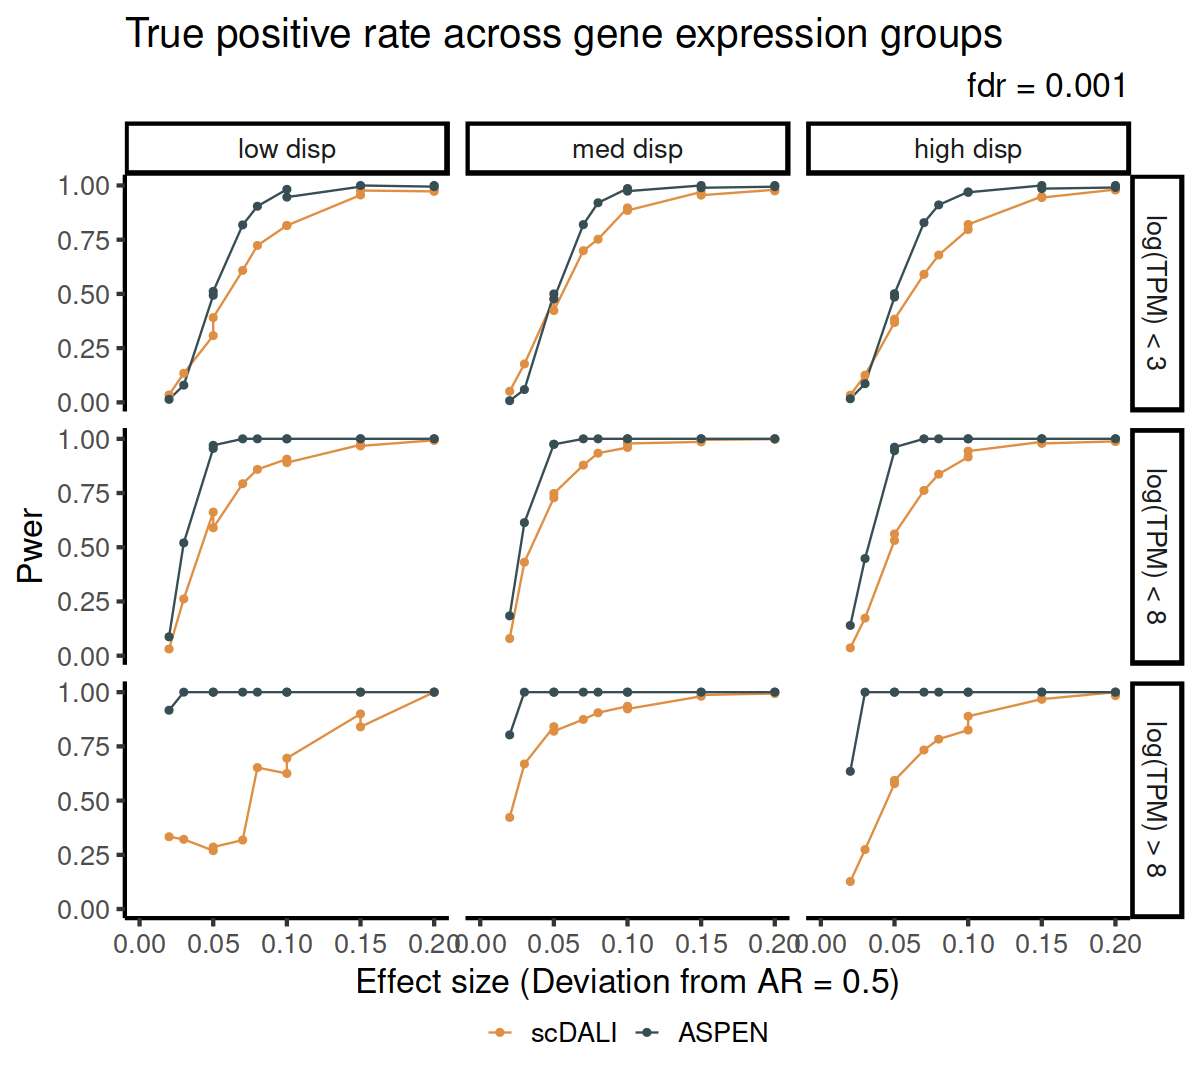

In [83]:
options(repr.plot.width = 10, repr.plot.height = 9)
#comparing only ASPEN and scDALI
summary_sub <- summary[summary$test != "nonBayes",]
summary_sub <- summary_sub[!(summary_sub$AR_vec) == 0,] 
plot_tpr(summary_sub) + facet_grid(factor(GE_group, levels = c("log(TPM) < 3", "log(TPM) < 8", "log(TPM) > 8"))~factor(disp_group, levels = c("low disp", "med disp", "high disp"))) +
  labs(title = "True positive rate across gene expression groups", subtitle = "fdr = 0.001") + theme(plot.subtitle = element_text(hjust = 1)) +
    xlim(0,0.2)

### Figure 3D

Checking expected allelic distribution patterns in make Bl6Spret F1 hybrids on chromosome X gene (Tmsb4x - Tcells dataset) and imprinted gene (Meg3 - mouse brain organoids).

In [85]:
#loading joint total and a1 counts
data_dir <-  "./data/tcells/"

tcells_tot_sce <- readRDS(paste0(data_dir, "merged_tcells_tot_sce.rds")) 
tcells_a1_sce <- readRDS(paste0(data_dir, "merged_tcells_a1_sce.rds")) 
tcells_a1_sce <- tcells_a1_sce[rownames(tcells_tot_sce), ]

metadata <- as.data.frame(colData(tcells_tot_sce))
metadata$group <- metadata$orig.ident
table(metadata$group)


cd8_d07_lcmv_arms cd8_d40_lcmv_arms         cd8_naive 
              400               582               723 

In [104]:
grouping <- split(metadata, f = metadata$group)
tcells_tot_sce_split <- lapply(grouping, function(q) tcells_tot_sce[,rownames(q)])
tot_sce_filt <- lapply(tcells_tot_sce_split, function(q) q[rowSums(assays(q)[['counts']] > 1) >= 10, ]) 
tot_mat <- lapply(tot_sce_filt, function(q) as.matrix(assays(q)[['counts']]))

tcells_a1_sce_split <- lapply(grouping, function(q) tcells_a1_sce[,rownames(q)])
a1_mat <- lapply(tcells_a1_sce_split, function(q) as.matrix(assays(q)[['counts']]))
a1_mat <- mapply(function(p,q) p[rownames(q), ], a1_mat, tot_mat, SIMPLIFY = F)
a2_mat <- mapply(function(p,q) p - q, tot_mat, a1_mat, SIMPLIFY = F)

In [112]:
gene = "Tmsb4x"
plot_data <- mapply(function(p, q) makedf(p, q, gene = gene),
                    a1_mat, a2_mat, SIMPLIFY = F)
plots <- mapply(function(p, q) plot_distr_totGE(p, gene),
                plot_data, samples, SIMPLIFY = F)

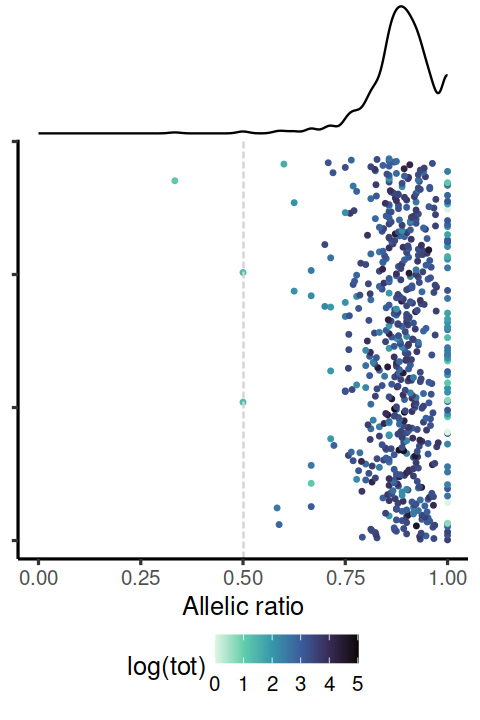

In [113]:
options(repr.plot.width = 4, repr.plot.height = 6)
plots[[2]] 

In [94]:
#Loading allelic counts
celltypes <- list("Cortical neurons", "IPCs", "RGCs")
res <- "./data/brain_organoids/Bl6Spret/"

a1_counts <- lapply(celltypes, function(q) read.csv(paste0(res, q, "B6_Spret_a1.csv")))
a1_counts <- lapply(a1_counts, function(q) tibble::column_to_rownames(q, var = "X"))

a2_counts <- lapply(celltypes, function(q) read.csv(paste0(res, q, "B6_Spret_a2.csv")))
a2_counts <- lapply(a2_counts, function(q) tibble::column_to_rownames(q, var = "X"))

In [117]:
gene = "Meg3"
plot_data <- mapply(function(p, q) makedf(p, q, gene = gene),
                    a1_counts, a2_counts, SIMPLIFY = F)
plots <- mapply(function(p, q) plot_distr_totGE(p, gene),
                plot_data, celltypes, SIMPLIFY = F)

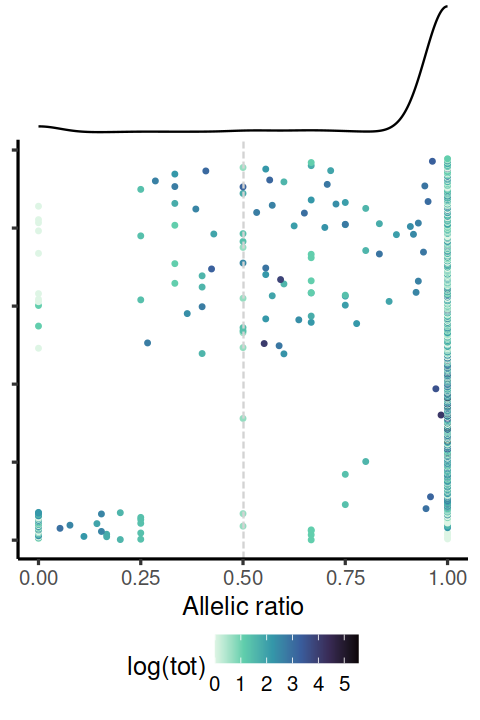

In [118]:
plots[[3]] 

### Figure 3E and Supplemental Figure 2B

Comparing ASPEN performance between pseudo-bulked and single cell allelic counts, using T-cells (male Bl6Spret hybrid) and brain organoids (female Bl6Cast hybrids) datasets.

In [120]:
#loading test results
#pseudo-bulked
res <- "./aspen_output/brain_organoids/Bl6Cast/"
cell_types <- c("Cortical neurons", "Gliogenic RGCs", "Other neurons", "Inhibitory neurons", 
                "IPCs", "RGCs", "OPCs", "Preplate neurons")
pseudobulk_res <- lapply(cell_types[-3], function(q) read.xlsx(paste0(res, "ASPEN_res_BL6_CAST.xlsx"), 
                                                               sheet = q, rowNames = T))
#keeping results for three neurodevelopment pathway cell types
pseudobulk_res <-  pseudobulk_res[c(1,4,5)]                         

#loading scRNA test results
celltypes <- list("Cortical neurons", "IPCs", "RGCs")

scRNA_res <- lapply(celltypes, function(q) read.xlsx(paste0(res, "Bl6_Cast_organoids_singlecell_ASPEN.xlsx"), 
                                                     sheet = paste0(q, "_Cast_B6"), rowNames = T))


Combining the results from pseudobulked and single cell analyses.

In [121]:
#finding a set of commong genes for eac cell type
common_genes <- mapply(function(p, q) rownames(p)[rownames(p) %in% rownames(q)], 
                                                  scRNA_res, pseudobulk_res, SIMPLIFY = F) 

scRNA_res_sub <- mapply(function(p, q) p[q,], scRNA_res, common_genes, SIMPLIFY = F)
pseudobulk_res_sub <- mapply(function(p, q) p[q,], pseudobulk_res, common_genes, SIMPLIFY = F)

cols_select <- c("mean_reestim", "theta_reestim", "pval_adj", "fdr_bayes")

plot_data <- mapply(function(p, q) as.data.frame(cbind(scRNA = p[,cols_select], pseudo_bulk = q[,cols_select])),
                    scRNA_res_sub, pseudobulk_res_sub, SIMPLIFY = F)

head(plot_data[[1]])

,scRNA.mean_reestim,scRNA.theta_reestim,scRNA.pval_adj,scRNA.fdr_bayes,pseudo_bulk.mean_reestim,pseudo_bulk.theta_reestim,pseudo_bulk.pval_adj,pseudo_bulk.fdr_bayes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Igfbpl1,0.7675,0.0685,0,0,0.7681,0.0106,2.377763e-39,1.780132e-37
Stmn1,0.9866,0.0059,0,0,0.9857,0.0026,0.000000e+00,0.000000e+00
Uchl1,0.9992,0.0003,0,0,0.9991,0.0004,0.000000e+00,0.000000e+00
Hmgb1,0.9772,0.0669,0,0,0.9745,0.0025,1.138648e-199,3.679031e-197
Gm9794,0.0124,0.0154,0,0,0.0126,0.0000,0.000000e+00,0.000000e+00
Ftl1,0.6851,0.0038,0,0,0.6846,0.0000,0.000000e+00,0.000000e+00


In [122]:
lapply(common_genes, length)

[[1]]
[1] 972

[[2]]
[1] 853

[[3]]
[1] 1072

In [125]:
plot_data_signscRNA <- lapply(plot_data, function(q) q[q$scRNA.fdr_bayes < 0.05,])
lapply(plot_data_signscRNA, function(q) dim(q[q$pseudo_bulk.pval_adj < 0.05,]))                              

[[1]]
[1] 499   8

[[2]]
[1] 397   8

[[3]]
[1] 447   8

In [126]:
scRNA_res_sign <- lapply(scRNA_res, function(q) q[q$fdr_bayes < 0.05,])
lapply(scRNA_res_sign, dim)

[[1]]
[1] 542  41

[[2]]
[1] 439  41

[[3]]
[1] 522  41

In [127]:
pseudobulk_res_sign <- lapply(pseudobulk_res, function(q) q[q$fdr_bayes < 0.05,])
lapply(pseudobulk_res_sign, dim)

[[1]]
[1] 1619   34

[[2]]
[1] 1233   34

[[3]]
[1] 1193   34

In [128]:
mapply(function(p, q) table(rownames(p) %in% rownames(q)), 
       scRNA_res_sign, pseudobulk_res_sign)

FALSE,97,98,135
TRUE,445,341,387


Correlation plots of FDR values obtained by running ASPEN on either pseudobulked or single cell allelic counts.

TableGrob (1 x 3) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]

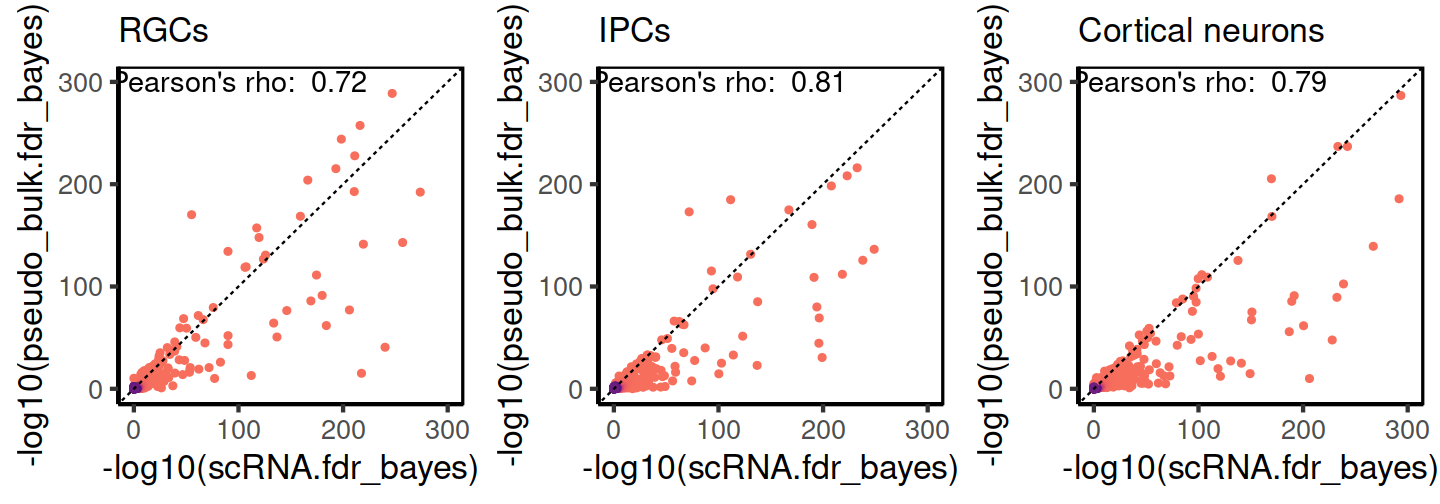

In [134]:
options(repr.plot.width = 12, repr.plot.height = 4.2)
p_scatter <- mapply(function(p,q) plot_scatter_kernel(p) +
                                          labs(subtitle = q) +
                                          ylim(0,300) +
                                          xlim(0,300),
                 plot_data[c(3,2,1)], celltypes[c(3,2,1)], SIMPLIFY = F)
scatters <- do.call(grid.arrange, c(p_scatter, ncol = 3))
scatters

In [135]:
#loading ASPEN results
#bulk RNA-seq results
res_dir <- "./aspen_output/tcells/"
samples <- list("cd8_naive", "cd8_d07_lcmv_arms", "cd8_d40_lcmv_arms")

bb_test_res_pseudobulk <- lapply(samples, function(q) read.xlsx(paste0(res_dir, "tcells_lcmv_ASPEN_pseudobulk.xlsx"),
                                                            sheet = q, rowNames = T))
bb_test_res_pseudobulk <- lapply(bb_test_res_pseudobulk, function(q) q[order(q$fdr_bayes),])
#scRNA results

bb_test_res_tcells <- lapply(samples, function(q) read.xlsx(paste0(res_dir, "tcells_lcmv_ASPEN.xlsx"),
                                                            sheet = q, rowNames = T))
bb_test_res_tcells <- lapply(bb_test_res_tcells, function(q) q[order(q$fdr_bayes),])

In [136]:
#finding a set of commong genes for eac cell type
common_genes <- mapply(function(p, q) rownames(p)[rownames(p) %in% rownames(q)], 
                                                  bb_test_res_tcells, bb_test_res_pseudobulk, SIMPLIFY = F) 

scRNA_res_sub <- mapply(function(p, q) p[q,], bb_test_res_tcells, common_genes, SIMPLIFY = F)
pseudobulk_res_sub <- mapply(function(p, q) p[q,], bb_test_res_pseudobulk, common_genes, SIMPLIFY = F)

cols_select <- c("mean_reestim", "theta_reestim", "pval_adj", "fdr_bayes")

plot_data <- mapply(function(p, q) as.data.frame(cbind(scRNA = p[,cols_select], pseudo_bulk = q[,cols_select])),
                    scRNA_res_sub, pseudobulk_res_sub, SIMPLIFY = F)

head(plot_data[[1]])

,scRNA.mean_reestim,scRNA.theta_reestim,scRNA.pval_adj,scRNA.fdr_bayes,pseudo_bulk.mean_reestim,pseudo_bulk.theta_reestim,pseudo_bulk.pval_adj,pseudo_bulk.fdr_bayes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rpl35,0.0128,0.0073,0,0,0.0128,0,0.000000e+00,0.000000e+00
Rps4x,0.9987,0.0001,0,0,0.9986,0,0.000000e+00,0.000000e+00
Tmsb4x,0.8760,0.0008,0,0,0.8761,0,0.000000e+00,0.000000e+00
Rpl27a,0.0178,0.0037,0,0,0.0178,0,0.000000e+00,0.000000e+00
Rps15,0.7404,0.0016,0,0,0.7403,0,1.817234e-156,2.673931e-154
Ppia,0.0214,0.0002,0,0,0.0214,0,1.288569e-300,2.654452e-298


In [137]:
lapply(common_genes, length)

[[1]]
[1] 221

[[2]]
[1] 525

[[3]]
[1] 768

In [138]:
lapply(plot_data, function(q) table(q$pseudo_bulk.fdr_bayes < 0.05 & q$scRNA.fdr_bayes < 0.05))

[[1]]

FALSE  TRUE 
   88   133 

[[2]]

FALSE  TRUE 
  295   230 

[[3]]

FALSE  TRUE 
  329   439 


In [139]:
bb_test_res_tcells_sign <- lapply(bb_test_res_tcells, function(q) q[q$fdr_bayes < 0.05,])
lapply(bb_test_res_tcells_sign, dim)

[[1]]
[1] 164  33

[[2]]
[1] 302  33

[[3]]
[1] 490  33

In [140]:
bb_test_res_pseudobulk_sign <- lapply(bb_test_res_pseudobulk, function(q) q[q$fdr_bayes < 0.05,])
lapply(bb_test_res_pseudobulk_sign, dim)

[[1]]
[1] 398  36

[[2]]
[1] 329  36

[[3]]
[1] 1310   36

In [141]:
mapply(function(p,q) table(rownames(p) %in% rownames(q)),
       bb_test_res_tcells_sign, bb_test_res_pseudobulk_sign)

FALSE,31,72,51
TRUE,133,230,439


TableGrob (1 x 3) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]

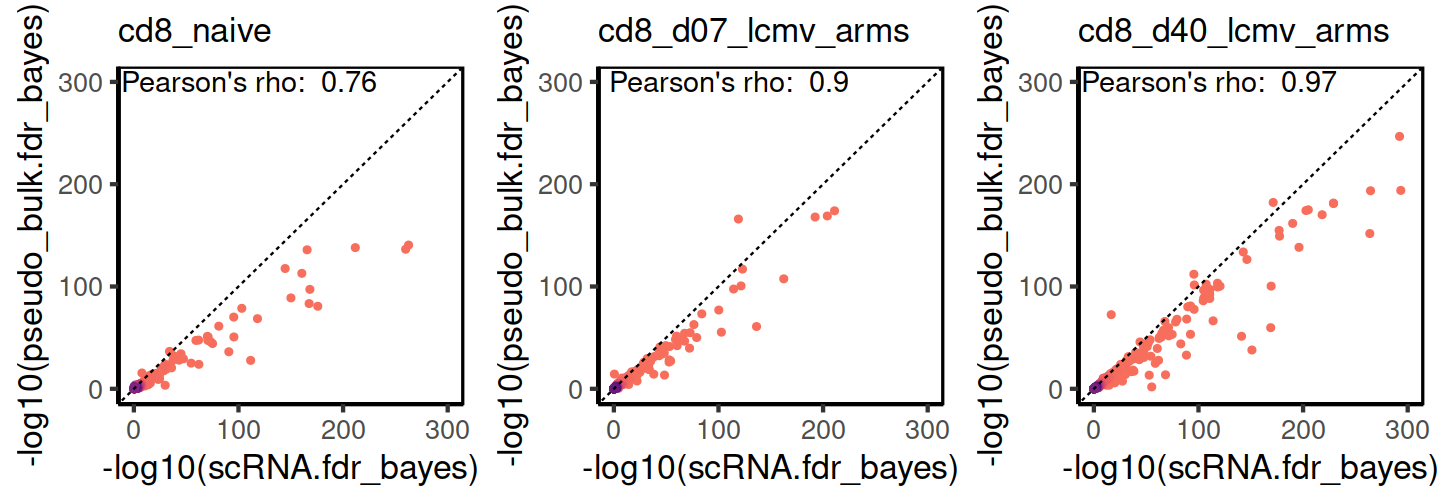

In [144]:
p_scatter <- mapply(function(p,q) plot_scatter_kernel(p) +
                                          labs(subtitle = q) +
                                          ylim(0,300) +
                                          xlim(0,300),
                 plot_data, samples, SIMPLIFY = F)
scatters <- do.call(grid.arrange, c(p_scatter, ncol = 3))
scatters

### Supplemental Figure 2C

Dispersion estimates over mean expression levels. All genes are included to build a representative local regression trend.

In [149]:
#using ASPEN to estimate beta-binomial parameters
param_estims_tcells <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat, tot_mat, SIMPLIFY = F)

param_reestims_tcells <- lapply(param_estims_tcells, function(q) correct_theta(q, delta_set = 50, N_set = 30, thetaFilter = 1e-03))

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


TableGrob (1 x 3) "arrange": 3 grobs
                  z     cells    name           grob
cd8_naive         1 (1-1,1-1) arrange gtable[layout]
cd8_d07_lcmv_arms 2 (1-1,2-2) arrange gtable[layout]
cd8_d40_lcmv_arms 3 (1-1,3-3) arrange gtable[layout]

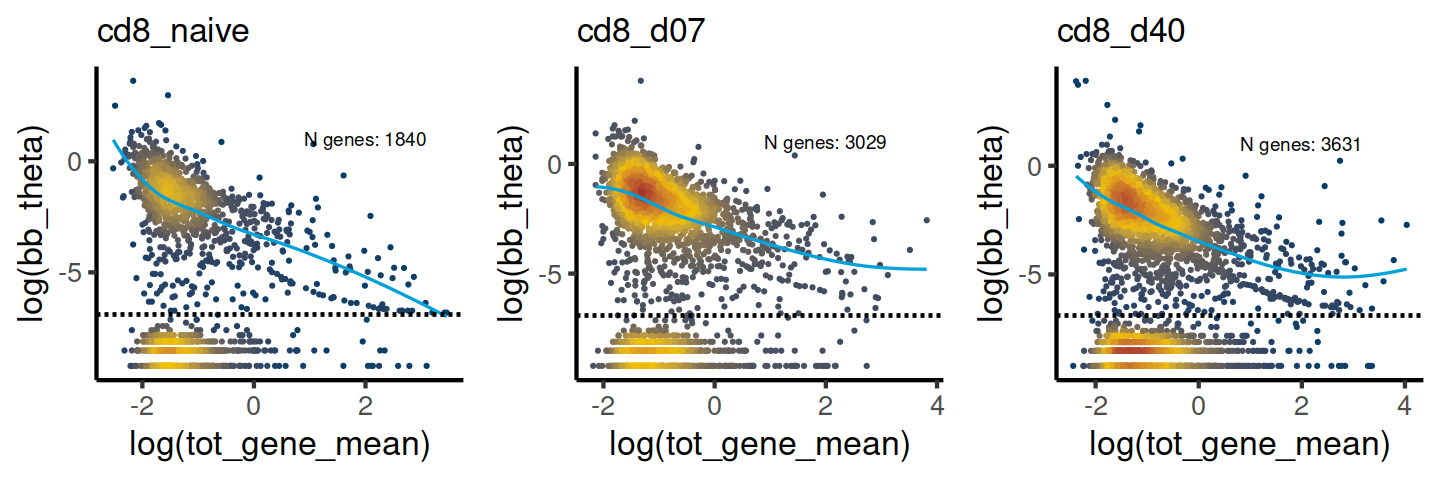

In [150]:
options(repr.plot.width = 12, repr.plot.height = 4)
samples <- list("cd8_naive", "cd8_d07", "cd8_d40")
p_disp <- mapply(function(p,q) plot_disp_fit_theta(p, midpoint = 200) +
                                          labs(subtitle = q) + geom_hline(yintercept = log(1e-03), linetype = "dashed", linewidth = 1),
                 param_reestims_tcells[c(3,1,2)], samples, SIMPLIFY = F)
disp_distr <- do.call(grid.arrange, c(p_disp, ncol = 3))
disp_distr

In [151]:
#Loading single-cell allelic counts for the female Bl6Cast hybrids
data_dir <- "./data/brain_organoids/Bl6Cast/"
allelic_counts <- readRDS(paste0(data_dir, "BL6CAST.organoids.allelic.counts.exons.rds"))

In [152]:
#adding cell annotations
#loading barcodes for the cells that pass filtering at the total count level 
annot <- read.xlsx("./data/misc/cells_pass_filter.xlsx", sheet = 1, colNames = T)
#subsetting to the most abundant cell type
annot <- annot[annot$cell_type %in% c("Deep layer neurons", "Gliogenic progenitor cells", 
                                      "Intermediate neuronal progenitors", "Neurogenic progenitor cells", 
                                      "Oligodendrocyte progenitor cells"),]
annot$cell_idents <- recode(annot$cell_type, `Deep layer neurons` = "Cortical neurons", 
                                            `Gliogenic progenitor cells` = "Gliogenic RGCs", 
                                            `Intermediate neuronal progenitors` = "IPCs", 
                                            `Neurogenic progenitor cells` = "RGCs", 
                                            `Oligodendrocyte progenitor cells` = "OPCs")

In [153]:
#adding batch information to metadata
colData(allelic_counts)$replicate <- gsub("_.*", "", colnames(allelic_counts))
colData(allelic_counts)$cell_type <- annot$cell_idents[match(gsub(".*_", "", rownames(colData(allelic_counts))), annot$cell_barcode_clean)]


In [155]:
#subsetting single cell objects by the cell types of interest
allelic_counts_sub <- allelic_counts[,allelic_counts$cell_type %in% c("Cortical neurons", "IPCs", "RGCs")]
dim(allelic_counts_sub)

[1] 13402  3691

In [156]:
#removing lowly expressed genes
allelic_counts_sub  <- allelic_counts_sub[rowSums(assays(allelic_counts_sub)[['tot']] > 1) >= 10, ]
dim(allelic_counts_sub)

[1] 7242 3691

In [157]:
#splitting count matrices by cell type
cell_ids <- as.data.frame(colData(allelic_counts_sub))
cell_list <- split(cell_ids, f = cell_ids$cell_type)

allelic_counts <- list()
for (i in 1:length(cell_list)){
    allelic_counts[[i]] <- allelic_counts_sub[,rownames(cell_list[[i]])]
}

table(colData(allelic_counts_sub)$cell_type)


Cortical neurons             IPCs             RGCs 
            1583             1182              926 

In [158]:
#only using genes that are expressed in at least 10 cells 
allelic_counts_filt <- lapply(allelic_counts, function(q) q[rowSums(assays(q)[['tot']] > 1) >= 10, ]) 
tot_mat <- lapply(allelic_counts_filt, function(q) as.matrix(assays(q)[['tot']]))

#splitting reference allele counts
a1_mat <- lapply(allelic_counts_filt, function(q) as.matrix(assays(q)[['a1']]))
#selecting genes that matched filtering criteria
a1_mat <- mapply(function(p,q) p[rownames(q), ], a1_mat, tot_mat, SIMPLIFY = F)

In [159]:
#checking that the order of genes in the reference allele and total count matrices is the same
mapply(function(p,q) table(rownames(p) == rownames(q)), tot_mat, a1_mat)

TRUE TRUE TRUE 
5025 4658 4901

In [160]:
#using ASPEN to estimate beta-binomial parameters
bb_init_params <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat, tot_mat, SIMPLIFY = F)
shrunk_estims <- lapply(bb_init_params, function(q) correct_theta(q, delta_set = 50, N_set = 30, thetaFilter = 0.001))    

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


TableGrob (1 x 3) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]

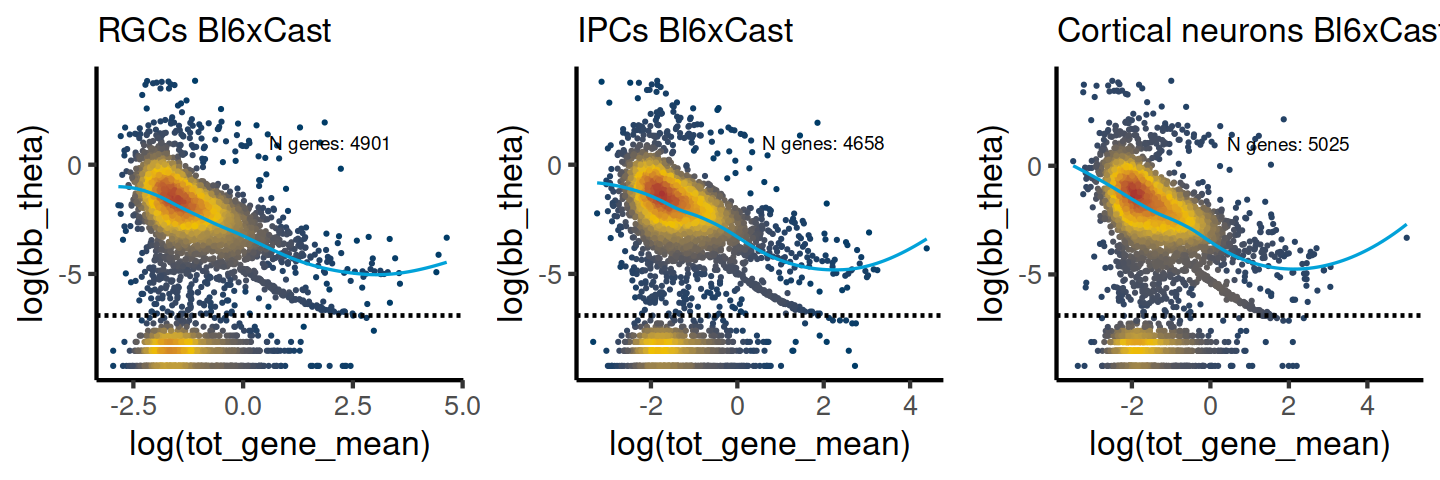

In [163]:
p_disp <- mapply(function(p,q) plot_disp_fit_theta(p, midpoint = 300) +
                                          labs(subtitle = paste0(q, " Bl6xCast")) + geom_hline(yintercept = log(1e-03), linetype = "dashed", linewidth = 1),
                 shrunk_estims[c(3,2,1)], celltypes[c(4,3,1)], SIMPLIFY = F)
disp_distr <- do.call(grid.arrange, c(p_disp, ncol = 3))
disp_distr

### Supplemental Figure 2D

Heatmap of the top 50 allelically imbalanced genes in T-cells.

In [164]:
#Loading ASPEN test results which excludes sex chromosome, imprinted and ribosomal genes 
samples <- list("cd8_d07_lcmv_arms", "cd8_d40_lcmv_arms", "cd8_naive")
res_dir <- "./aspen_output/tcells/"
bb_test_res_tcells_filt <- lapply(samples, function(q) read.xlsx(paste0(res_dir, "tcells_lcmv_ASPENmeanvar_nochrX.xlsx"),
                                                            sheet = q, rowNames = T))

In [166]:
#selecting genes with significant allelic imbalance
bb_test_res_tcells_select <- lapply(bb_test_res_tcells_filt, function(q) q[q$fdr_mean < 0.05,])
bb_test_res_tcells_select <- lapply(bb_test_res_tcells_select, function(q) q[order(q$fdr_mean),])
bb_test_res_tcells_select <- lapply(bb_test_res_tcells_select, function(q) q[1:58,])                            
genes <- unique(c(rownames(bb_test_res_tcells_select[[1]]), 
                  rownames(bb_test_res_tcells_select[[2]]), 
                  rownames(bb_test_res_tcells_select[[3]])))
length(genes)

[1] 116

In [167]:
#building a table with mean AR values per cell type for plotting
bb_test_res_tcells_select <- lapply(bb_test_res_tcells_filt, function(q) q[genes,])
#selecting allelic ratio estimated using raw counts
top50genes_ar <- lapply(bb_test_res_tcells_select, function(q) q[,"AR"])
top50genes_ar <- do.call("cbind", top50genes_ar)
colnames(top50genes_ar) <- c("cd8_d07", "cd8_d40", "cd8_naive")
rownames(top50genes_ar) <- genes 
#re-ordering table columns
top50genes_ar <- top50genes_ar[,c(3,1,2)]
top50genes_ar <- na.omit(top50genes_ar)
head(top50genes_ar)

,cd8_naive,cd8_d07,cd8_d40
Ppia,0.0199518,0.0151674,0.009963239
Calm1,0.8794384,0.9306838,0.942826426
Epsti1,0.8424902,0.8966328,0.880161425
Myl6,0.3409497,0.2378631,0.244962434
Thy1,0.8739194,0.8903806,0.865473020
Btf3,0.2083208,0.1589957,0.174500046


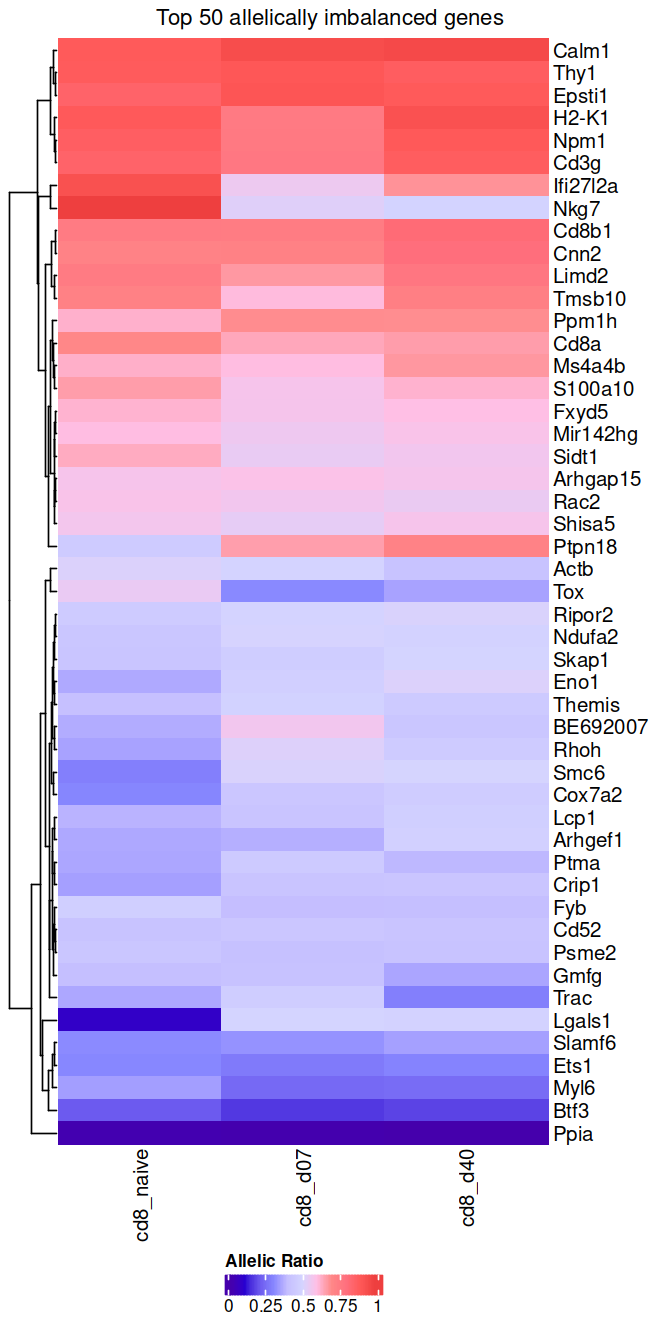

In [171]:
options(repr.plot.width = 5.5, repr.plot.height = 11)
cont_pal <- pal_gsea()(11)
ht <- ComplexHeatmap::Heatmap(top50genes_ar, cluster_rows = T, cluster_columns = FALSE, col = cont_pal, 
                        heatmap_legend_param = list(direction = "horizontal", at = seq(0, 1, 0.25)), name = "Allelic Ratio",
                        row_names_side = "right")
draw(ht, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"), column_title="Top 50 allelically imbalanced genes")